1. PM2.5, PM10 représentent PM1
2. SO2 représnete O2
3. l'humidité, CO représente dewpt
4. O3 représente CO2   CO2 représente TVOC

In [201]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [202]:

data=pd.read_csv("./one_room_apartement.csv")

In [203]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [204]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [205]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

In [206]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

'pm1','oxygen','tvoc','co2','dewpt'

In [207]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3','pm1','oxygen','tvoc','co2','dewpt'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [208]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [209]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                       pm10     co      so2     no2      o3   sound   pm2_5  \
date                                                                          
2023-07-08 23:40:25  14.125  1.626  1139.90  69.921  43.117  52.546  12.716   
2023-07-08 23:42:24  13.626  1.625  1138.44  70.182  43.263  54.409  12.753   
2023-07-08 23:44:25  16.510  1.624  1136.82  70.427  43.142  53.219  14.302   
2023-07-08 23:46:25  17.540  1.621  1134.34  70.437  43.111  52.719  15.671   
2023-07-08 23:48:26  18.675  1.619  1132.36  70.288  43.052  52.106  16.187   
2023-07-08 23:50:26  15.895  1.616  1128.76  70.419  43.174  52.033  14.813   
2023-07-08 23:52:25  17.712  1.613  1123.33  70.439  43.357  51.868  17.004   
2023-07-08 23:54:26  15.942  1.611  1118.35  70.315  43.350  52.146  15.244   
2023-07-08 23:56:28  15.670  1.609  1115.68  69.342  42.934  53.363  14.407   
2023-07-08 23:58:27  18.649  1.607  1114.81  68.738  42.728  52.157  17.031   

                     temperature  pressure  humidit

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

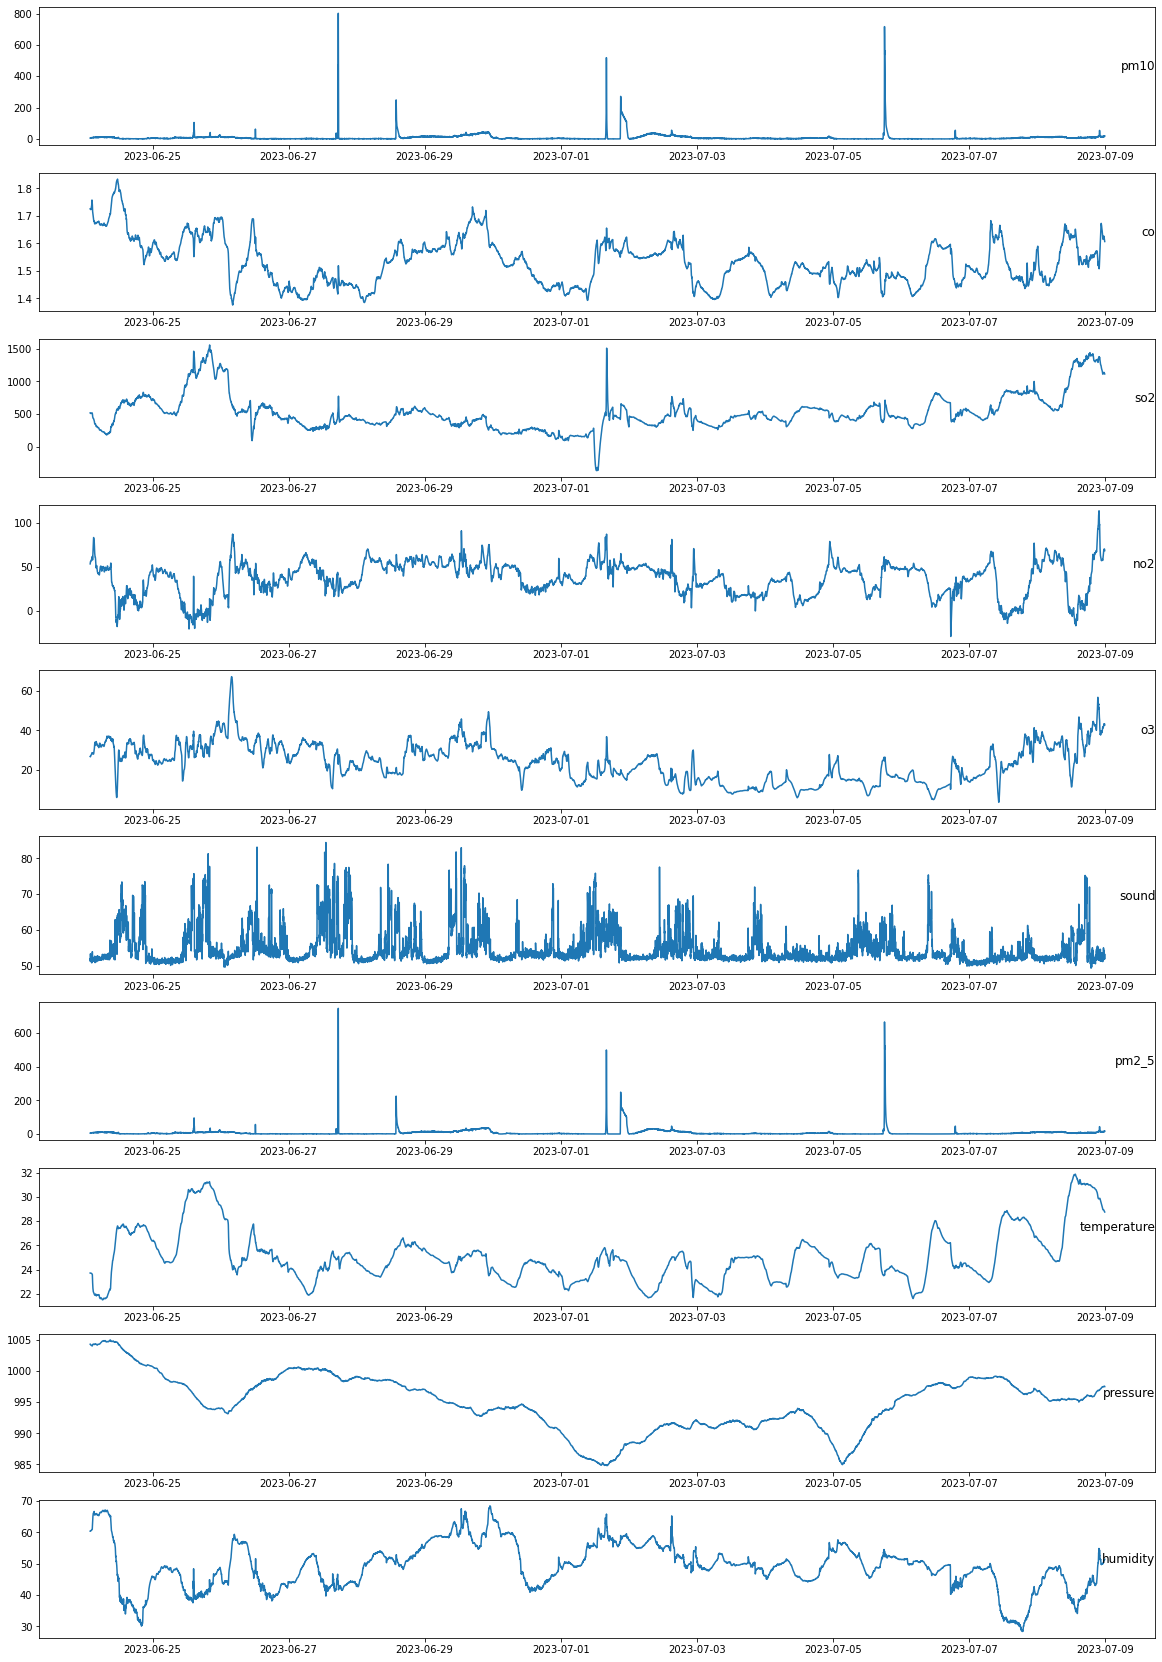

In [210]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [211]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [212]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [213]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.007486,0.763676,0.459352,0.577556,0.365211,0.068824,0.007231,0.213425,0.966908,0.798549,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636
2,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636,0.213135,0.965919,0.798350,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175
3,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175,0.213232,0.964931,0.797876,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348
4,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348,0.213521,0.963943,0.799571,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000
5,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000,0.212846,0.962955,0.799795,0.008857,0.759300,0.457025,0.597494,0.367301,0.067623,0.007897


80% train - 20% test
Ligne de départ de l'ensemble de données de test = train_x.shape[0]+1(onglet)+x(projetée)+1(test)
（2023-06-24 02:01:10<3> - 2023-07-06 00:18:22<8559>）         （2023-07-06 00:20:20<8560> - 2023-07-08 23:58:27<10698>）

In [214]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-7].values, train.iloc[:, -7:].values
test_X, test_y = test.iloc[:, :-7].values, test.iloc[:, -7:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 1, 10) (8557, 7) (2139, 1, 10) (2139, 7)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 11 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 14 caractéristiques.

In [215]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(7))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 707       
Total params: 45,107
Trainable params: 45,107
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/400
119/119 - 1s - loss: 0.1126 - val_loss: 0.0817
Epoch 2/400
119/119 - 0s - loss: 0.0779 - val_loss: 0.0732
Epoch 3/400
119/119 - 0s - loss: 0.0687 - val_loss: 0.0632
Epoch 4/400
119/119 - 0s - loss: 0.0608 - val_loss: 0.0536
Epoch 5/400
119/119 - 0s - loss: 0.0519 - val_loss: 0.0440
Epoch 6/400
119/119 - 0s - loss: 0.0448 - val_loss: 0.0388
Epoch 7/400
119/119 - 0s - loss: 0.0399 - val_loss: 0.0359
Epoch 8/400
119/119 - 0s - loss: 0.0373 - val_loss: 0.0350
Epoch 9/400
119/119 - 0s - loss: 0.0357 - val_loss: 0.0336
Epoch 10/400
119/119 - 0s - loss: 0.0342 - val_loss: 0.0318
Epoch 11/400
119/119 - 0s - loss: 0.0329 - val_loss: 0.0299
Epoch 12/400
119/119 - 0s - loss: 0.0314 - val_loss: 0.0282
Epoch 13/400
119/119 - 0s - loss: 0.0307 - val_loss: 0.0282
Epoch 14/400
119/119 - 0s - loss: 0.0298 - val_loss: 0.0282
Epoch 15/400
119/119 - 0s - loss: 0.0290 - val_loss: 0.0290
Epoch 16/400
119/119 - 0s - loss: 0.0286 - val_loss: 0.0290
Epoch 17/400
119/119 - 0s - loss: 0.0280 - val_lo

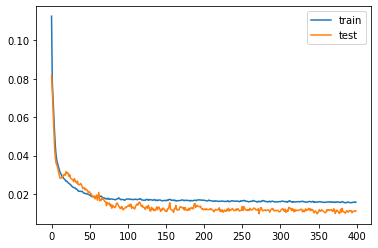

In [216]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

Les prédictions de sortie sont obtenues grâce au modèle, puis les valeurs réelles sont obtenues à partir des données d'origine.

In [217]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [7, 8, 9]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)


       0      1           2          3       4          5      6
0  1.002  1.479  438.337982  47.824005  15.432  52.966000  0.699
1  0.485  1.479  437.725983  47.506008  15.361  52.457001  0.118
2  0.378  1.478  435.914001  47.601002  15.342  52.323002  0.336
3  0.836  1.478  435.846954  47.555004  15.323  51.528999  0.527
4  0.734  1.478  436.254974  47.664001  15.343  51.537998  0.502


Afficher valeur pic sur tvoc

Comme je veux trouver la relation entre les paramètres, je vais choisir des valeurs de pic pour découvrir la relation entre les paramètres. Mais cela semble lourd et difficile à observer, nous utilisons la méthode de la carte thermique pour y parvenir.

In [218]:
# col_index = 8
# col_values = inv_y_df.iloc[:, col_index]

# filtered_rows = col_values[col_values > 8000]
# date_indices = filtered_rows.index + train_X.shape[0] + 1
# datepic = data.iloc[date_indices, col_index]
# for index, value in filtered_rows.items():
#     print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

Comparaison des valeurs prédites et des valeurs réelles pour 12 valeurs de sortie

In [219]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


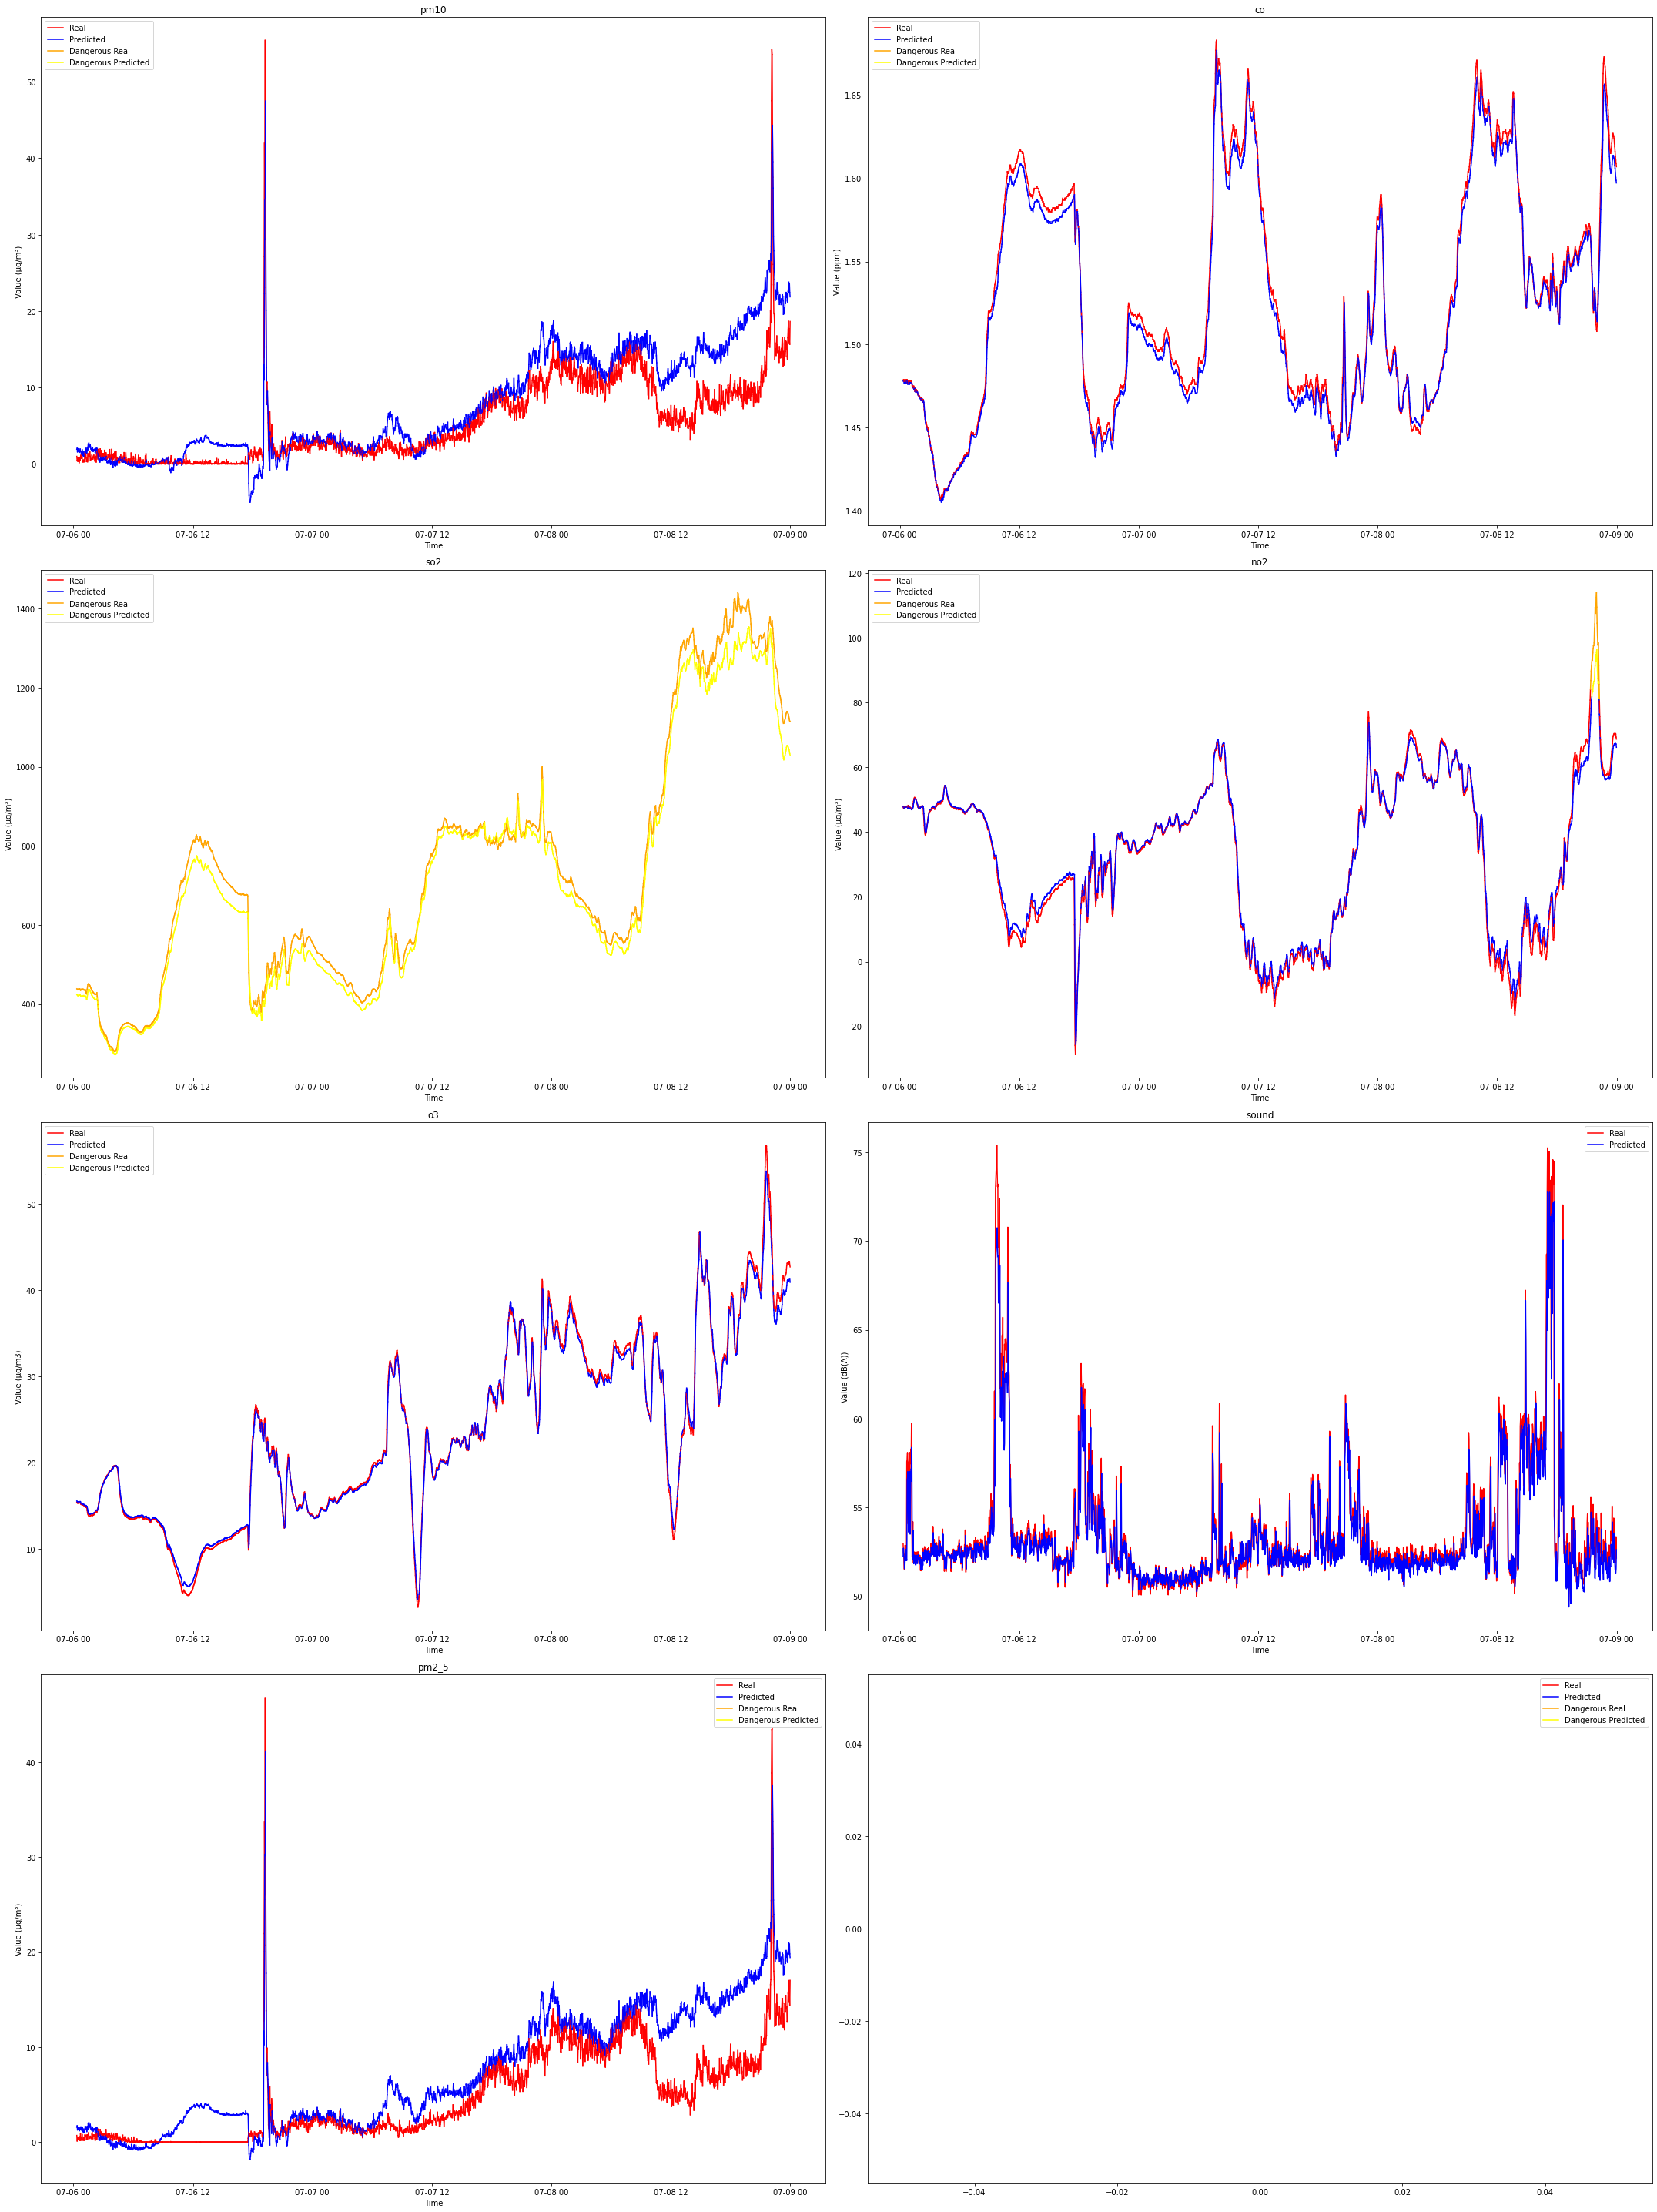

In [220]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 2, figsize=(30, 40))
feature_indices = {
    'pm10': 0, 'co': 1, 'so2': 2,
    'no2': 3, 'o3' : 4, 'sound': 5, 'pm2_5': 6
}

feature_units = {
    'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 2
    col = i % 2

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

Calcul de l'RMSE(Root Mean Square Error)

In [221]:

print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [7, 8, 9]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['pm10', 'co', 'so2', 'no2', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # # Avoid division by zero for MAPE
    # actual_values = inv_y[:, i]
    # predicted_values = inv_yhat[:, i]
    # # Replace zeros in actual values with a small number (1e-10)
    # actual_values = np.where(actual_values == 0, 1e-10, actual_values)
    # mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(2139, 7) (2139, 7)
Test RMSE for pm10: 3.978
Test RMSE for co: 0.006
Test RMSE for so2: 37.712
Test RMSE for no2: 2.559
Test RMSE for o3: 0.716
Test RMSE for sound: 1.432
Test RMSE for pm2_5: 3.969


In [222]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [223]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

PM2.5 (Particulate Matter 2.5-micrometer)

PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [224]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 6]
inv_y_PM25_values = inv_y[:, 6]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

PM10 (Particulate Matter 10-micrometer)

PM10 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [225]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 0]
inv_y_PM10_values = inv_y[:, 0]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

SO2 (Sulphur Dioxide)

SO2 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [226]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 2]
inv_y_SO2_values = inv_y[:, 2]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

NO2 (Any Nitric x-oxide)

NO2 is measured in ppb (parts per billion). The predefined groups are defined in the function below:

In [227]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 3]
inv_y_NO2_values = inv_y[:, 3]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

CO (Carbon Monoxide)

CO is measured in mg / m3 (milligrams per cubic meter of air). The predefined groups are defined in the function below:

In [228]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 1]
inv_y_CO_values = inv_y[:, 1]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

O3 (Ozone or Trioxygen)

O3 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [229]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 4]
inv_y_O3_values = inv_y[:, 4]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

In [230]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 7
PM10_SubIndex_col = 8
SO2_SubIndex_col = 9
NO2_SubIndex_col = 10
CO_SubIndex_col = 11
O3_SubIndex_col = 12

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

       col0      col1        col2       col3       col4       col5      col6  \
0  1.932149  1.478071  423.387238  47.975628  15.573950  52.245888  1.564502   
1  2.061582  1.478138  422.958984  47.757229  15.539931  52.713562  1.709713   
2  1.591543  1.478018  422.413910  47.481995  15.476851  52.302090  1.280552   
3  1.656312  1.477050  420.903900  47.571285  15.460681  52.191067  1.321513   
4  1.987575  1.476918  421.125793  47.564285  15.453914  51.554768  1.563841   

       col7      col8        col9      col10      col11      col12  \
0  2.607503  1.932149  210.330295  31.871301  84.664134  15.573950   
1  2.849521  2.061582  210.228330  31.726213  84.668005  15.539931   
2  2.134253  1.591543  210.098550  31.543369  84.661122  15.476851   
3  2.202522  1.656312  209.739024  31.602687  84.605656  15.460681   
4  2.606402  1.987575  209.791856  31.598037  84.598104  15.453914   

   AQI_calculated  Checks AQI_bucket_calculated  
0      210.330295     6.0                  Poor 

In [231]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.7971014492753623


In [232]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 


1705


anticiper

In [233]:
# 7*2 = 14 min
n_temps = 7
n_features = 10

reframed = series_to_supervised(scaled, n_temps, 1)

In [234]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
7,0.007486,0.763676,0.459352,0.577556,0.365211,0.068824,0.007231,0.213425,0.966908,0.798549,...,0.212171,0.960484,0.800419,0.008789,0.757112,0.454809,0.596099,0.370624,0.079570,0.008455
8,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636,0.213135,0.965919,0.798350,...,0.212267,0.959991,0.800543,0.009619,0.759300,0.454247,0.596541,0.373339,0.056076,0.009624
9,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175,0.213232,0.964931,0.797876,...,0.212075,0.959003,0.802189,0.008591,0.761488,0.454146,0.598910,0.373994,0.078770,0.008112
10,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348,0.213521,0.963943,0.799571,...,0.212075,0.958511,0.803161,0.009048,0.761488,0.454584,0.599891,0.374384,0.068967,0.009314
11,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000,0.212846,0.962955,0.799795,...,0.211689,0.958015,0.802388,0.007789,0.768053,0.455741,0.601804,0.376053,0.074111,0.008089
12,0.008857,0.759300,0.457025,0.597494,0.367301,0.067623,0.007897,0.212171,0.961475,0.800369,...,0.211496,0.958015,0.803485,0.009407,0.772429,0.456684,0.604957,0.379095,0.056819,0.009522
13,0.008218,0.759300,0.455760,0.596975,0.369095,0.058020,0.008322,0.212171,0.960484,0.800419,...,0.211206,0.957523,0.804208,0.008095,0.776805,0.457308,0.607487,0.381638,0.062364,0.008471
14,0.008789,0.757112,0.454809,0.596099,0.370624,0.079570,0.008455,0.212267,0.959991,0.800543,...,0.210917,0.957027,0.804981,0.009595,0.781182,0.457578,0.611405,0.383354,0.045587,0.009887
15,0.009619,0.759300,0.454247,0.596541,0.373339,0.056076,0.009624,0.212075,0.959003,0.802189,...,0.210724,0.957027,0.808521,0.009814,0.783370,0.457142,0.614481,0.385710,0.059049,0.009942
16,0.008591,0.761488,0.454146,0.598910,0.373994,0.078770,0.008112,0.212075,0.958511,0.803161,...,0.210339,0.957027,0.809817,0.009958,0.792123,0.457181,0.616324,0.387675,0.071653,0.010300


In [235]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 70) (8557, 7) (2133, 70) (2133, 7)


In [236]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(2133, 7, 10) (8557, 7, 10)


In [237]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(7))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 707       
Total params: 45,107
Trainable params: 45,107
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/400
119/119 - 1s - loss: 0.0934 - val_loss: 0.0704
Epoch 2/400
119/119 - 1s - loss: 0.0684 - val_loss: 0.0507
Epoch 3/400
119/119 - 1s - loss: 0.0561 - val_loss: 0.0442
Epoch 4/400
119/119 - 1s - loss: 0.0488 - val_loss: 0.0412
Epoch 5/400
119/119 - 1s - loss: 0.0429 - val_loss: 0.0345
Epoch 6/400
119/119 - 1s - loss: 0.0385 - val_loss: 0.0342
Epoch 7/400
119/119 - 1s - loss: 0.0381 - val_loss: 0.0465
Epoch 8/400
119/119 - 1s - loss: 0.0362 - val_loss: 0.0342
Epoch 9/400
119/119 - 1s - loss: 0.0330 - val_loss: 0.0271
Epoch 10/400
119/119 - 1s - loss: 0.0334 - val_loss: 0.0283
Epoch 11/400
119/119 - 1s - loss: 0.0307 - val_loss: 0.0281
Epoch 12/400
119/119 - 1s - loss: 0.0308 - val_loss: 0.0341
Epoch 13/400
119/119 - 1s - loss: 0.0307 - val_loss: 0.0333
Epoch 14/400
119/119 - 1s - loss: 0.0302 - val_loss: 0.0350
Epoch 15/400
119/119 - 1s - loss: 0.0294 - val_loss: 0.0363
Epoch 16/400
119/119 - 1s - loss: 0.0288 - val_loss: 0.0352
Epoch 17/400
119/119 - 1s - loss: 0.0283 - val_lo

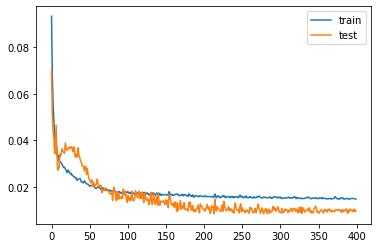

In [238]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [239]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [7, 8, 9]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

       0      1           2          3       4          5      6
0  0.494  1.478  438.166992  47.861004  15.370  52.881001  0.491
1  0.174  1.479  437.809021  47.721004  15.375  52.095001  0.174
2  0.389  1.478  437.946014  47.740005  15.366  52.841000  0.389
3  0.780  1.478  438.044983  47.889004  15.388  52.228001  0.558
4  0.492  1.478  436.010010  47.858002  15.355  52.105000  0.172


In [240]:
# col_index = 8
# col_values = inv_y_df.iloc[:, col_index]

# date_indices = filtered_rows.index + train_X.shape[0] + 1
# datepic = data.iloc[date_indices, col_index]
# for index, value in filtered_rows.items():
#     print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

In [241]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


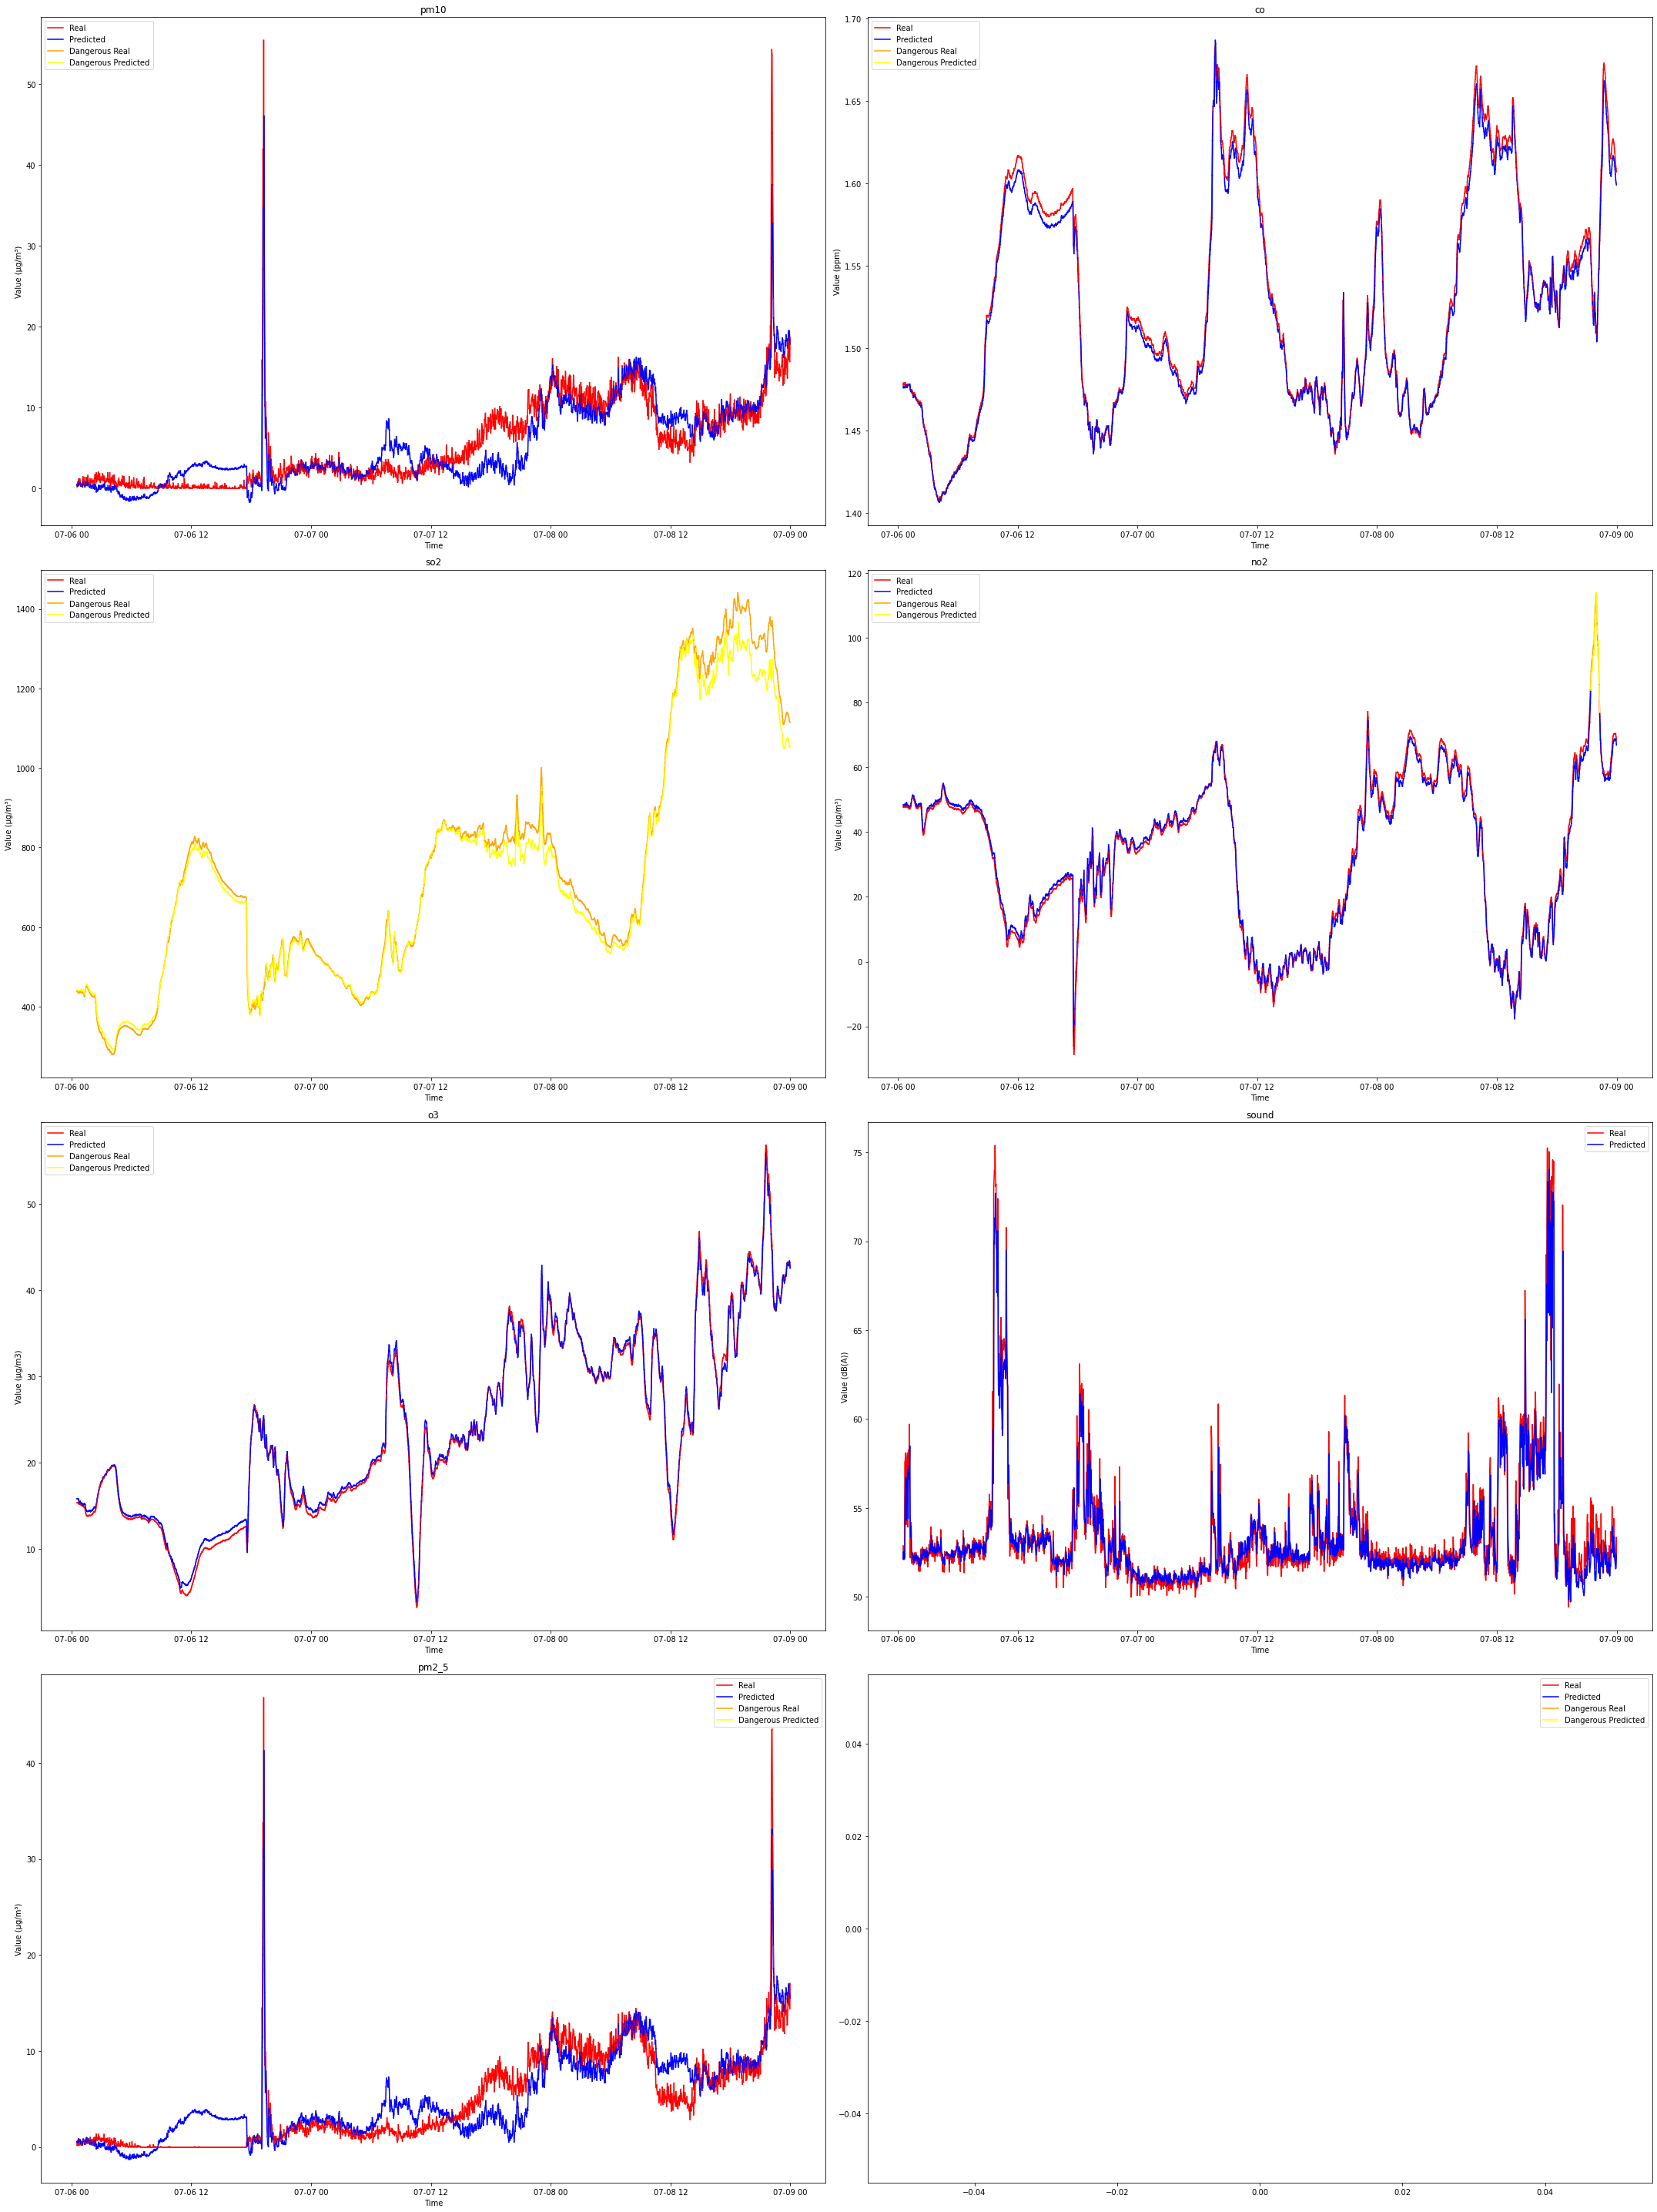

In [242]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 2, figsize=(30, 40))
feature_indices = {
    'pm10': 0, 'co': 1, 'so2': 2,
    'no2': 3, 'o3' : 4, 'sound': 5, 'pm2_5': 6
}
feature_units = {
    'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}


for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 2
    col = i % 2

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()


L'ensemble de tests commence par des données de comptage à la ligne 9393

In [243]:
print(inv_y.shape, inv_yhat.shape)

(2133, 7) (2133, 10)


In [244]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [7,8,9]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [245]:
feature_names = ['pm10', 'co', 'so2', 'no2', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

Test RMSE for pm10: 2.635
Test RMSE for co: 0.006
Test RMSE for so2: 33.160
Test RMSE for no2: 1.744
Test RMSE for o3: 0.625
Test RMSE for sound: 1.403
Test RMSE for pm2_5: 2.423


In [246]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 6]
inv_y_PM25_values = inv_y[:, 6]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [247]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 0]
inv_y_PM10_values = inv_y[:, 0]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [248]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 2]
inv_y_SO2_values = inv_y[:, 2]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [249]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 3]
inv_y_NO2_values = inv_y[:, 3]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [250]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 1]
inv_y_CO_values = inv_y[:, 1]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [251]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 4]
inv_y_O3_values = inv_y[:, 4]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [252]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 7
PM10_SubIndex_col = 8
SO2_SubIndex_col = 9
NO2_SubIndex_col = 10
CO_SubIndex_col = 11
O3_SubIndex_col = 12

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

       col0      col1        col2       col3       col4       col5      col6  \
0  0.390267  1.477132  441.614777  48.468121  15.840313  52.132473  0.547619   
1  0.465712  1.476101  442.286835  48.380169  15.819826  52.527405  0.602462   
2  0.264161  1.476995  442.213470  48.216118  15.819847  52.125175  0.436467   
3  0.336834  1.476238  441.727966  48.263119  15.810674  52.567051  0.488917   
4  0.574955  1.476223  441.617828  48.493282  15.840219  52.241608  0.709309   

       col7      col8        col9      col10      col11      col12  \
0  0.912699  0.390267  214.670185  32.198475  84.610381  15.840313   
1  1.004103  0.465712  214.830199  32.140047  84.551289  15.819826   
2  0.727445  0.264161  214.812731  32.031064  84.602501  15.819847   
3  0.814862  0.336834  214.697135  32.062287  84.559148  15.810674   
4  1.182181  0.574955  214.670912  32.215190  84.558294  15.840219   

   AQI_calculated  Checks AQI_bucket_calculated  
0      214.670185     6.0                  Poor 

In [253]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

In [254]:
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.7899671823722456


In [255]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1685
